In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import random as rn
warnings.filterwarnings("ignore")

In [2]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [3]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [4]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [5]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [6]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [7]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [8]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [9]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [10]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [11]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [12]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [13]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [14]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [15]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [16]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [17]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [18]:
def plot_performance_metrics(df , colors=None, labels = None, y_min = 0.0, frame_color = 'gray', frame_width = 0.5, x_label_rotation = 45, tick_size = 14,legend_fontsize = 12,
                            legend_labels = None, legend_loc = 'upper center', legend_bbox_to_anchor=(0.5, -0.2), legend_ncol=4, save=False, save_path=None):

    # Default values
    default_colors = ['#5E0B8A', '#00A7E1', '#BDDA57', '#FF8C00']
    default_labels = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]
    default_legend_labels =['scATAcat', 'Seurat label transfer', 'Cellcano', 'EpiAnno']

    # Use default if None is passed
    colors = default_colors if colors is None else colors
    labels = default_labels if labels is None else labels
    legend_labels = default_legend_labels if legend_labels is None else legend_labels
  
    df.columns = labels
    df.index = legend_labels
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    n_bins = 100  # Increase this number for a smoother gradient
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    ax = df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=cmap)
    ax.set_ylim(ymin=y_min)
    # Change plot frame to gray and adjust linewidth
    spine_color = 'gray'
    linewidth = frame_width # Adjust the linewidth as needed
    for spine in ax.spines.values():
        spine.set_color(spine_color)
        spine.set_linewidth(linewidth)
    ax.legend(legend_labels,fontsize=legend_fontsize, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=False, shadow=False, ncol=legend_ncol, frameon=False)
    plt.xticks(rotation=x_label_rotation)
    plt.tick_params(axis='both', which='major', labelsize=tick_size)

    if save == False:
        plt.show()
    else:
        if save_path == None:
            print("specify the save_path directory")
        else:
            plt.savefig(save_path, bbox_inches='tight', transparent=True)

In [19]:
paper_metadata = pd.read_csv("../../../data/Corces2020_brain_scATAC/05_get_cell_annotations/CAUD_06_0615_neuronal_cluster_df_cell_type_annotations.csv", index_col=0)

In [20]:
paper_metadata.index=paper_metadata['cell_IDs']
paper_metadata = paper_metadata[["cell_IDs", "annotations"]]
paper_metadata.index.name = None
paper_metadata.columns = [["cell_IDs", "cell_type"]]

In [21]:
paper_metadata

,cell_IDs,cell_type
AAACGAAAGCAGAGCT-1,AAACGAAAGCAGAGCT-1,InhibitoryNeurons
AAACGAAAGCTGATTC-1,AAACGAAAGCTGATTC-1,Oligodendrocytes
AAACGAAAGGACCGAT-1,AAACGAAAGGACCGAT-1,InhibitoryNeurons
AAACGAAAGGAGTACC-1,AAACGAAAGGAGTACC-1,Oligodendrocytes
AAACGAAAGTCGTATC-1,AAACGAAAGTCGTATC-1,UnknownNeurons
...,...,...
TTTGTGTTCCTAAAGC-1,TTTGTGTTCCTAAAGC-1,InhibitoryNeurons
TTTGTGTTCCTCATTA-1,TTTGTGTTCCTCATTA-1,Oligodendrocytes
TTTGTGTTCGGTCGAC-1,TTTGTGTTCGGTCGAC-1,InhibitoryNeurons
TTTGTGTTCTCCCTTT-1,TTTGTGTTCTCCCTTT-1,InhibitoryNeurons


In [22]:
paper_metadata_rename_dict = {"Oligodendrocytes":"OLIG",
                              "InhibitoryNeurons":"GABA",
                              "Microglia":"MGAS",
                              "OPCs":"OLIG",
                              "Astrocytes":"MGAS",  
                              "UnknownNeurons":"UnknownNeurons",
                              "ExcitatoryNeurons":"GLU",
                              "Doublets":"Doublets",
                              "NigralNeurons":"NigralNeurons"}

In [23]:
paper_metadata_rename_dict


{'Oligodendrocytes': 'OLIG',
 'InhibitoryNeurons': 'GABA',
 'Microglia': 'MGAS',
 'OPCs': 'OLIG',
 'Astrocytes': 'MGAS',
 'UnknownNeurons': 'UnknownNeurons',
 'ExcitatoryNeurons': 'GLU',
 'Doublets': 'Doublets',
 'NigralNeurons': 'NigralNeurons'}

In [24]:
paper_metadata['ground_truth_annotations_simplified'] = paper_metadata["cell_type"].replace(paper_metadata_rename_dict)
paper_metadata.index.name = None
paper_metadata.columns=["cell_IDs", "ground_truth_annotations","ground_truth_annotations_simplified" ]
paper_metadata

,cell_IDs,ground_truth_annotations,ground_truth_annotations_simplified
AAACGAAAGCAGAGCT-1,AAACGAAAGCAGAGCT-1,InhibitoryNeurons,GABA
AAACGAAAGCTGATTC-1,AAACGAAAGCTGATTC-1,Oligodendrocytes,OLIG
AAACGAAAGGACCGAT-1,AAACGAAAGGACCGAT-1,InhibitoryNeurons,GABA
AAACGAAAGGAGTACC-1,AAACGAAAGGAGTACC-1,Oligodendrocytes,OLIG
AAACGAAAGTCGTATC-1,AAACGAAAGTCGTATC-1,UnknownNeurons,UnknownNeurons
...,...,...,...
TTTGTGTTCCTAAAGC-1,TTTGTGTTCCTAAAGC-1,InhibitoryNeurons,GABA
TTTGTGTTCCTCATTA-1,TTTGTGTTCCTCATTA-1,Oligodendrocytes,OLIG
TTTGTGTTCGGTCGAC-1,TTTGTGTTCGGTCGAC-1,InhibitoryNeurons,GABA
TTTGTGTTCTCCCTTT-1,TTTGTGTTCTCCCTTT-1,InhibitoryNeurons,GABA


In [25]:
paper_metadata_known = paper_metadata[paper_metadata['ground_truth_annotations_simplified']!= "UnknownNeurons"]

### seurat annotations

In [26]:
seurat_labelTransfer_annotations = pd.read_csv("../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_seurat_label_transfer/Corces2020_seurat_label_transfer_annotations.csv", index_col = 0)
seurat_labelTransfer_annotations["cell_IDs"] = seurat_labelTransfer_annotations.index
seurat_labelTransfer_annotations.head()

,predicted_cell_type,cell_IDs
AAACGAAAGCAGAGCT-1,Inh,AAACGAAAGCAGAGCT-1
AAACGAAAGGACCGAT-1,Exc,AAACGAAAGGACCGAT-1
AAACGAAAGTCGTATC-1,Inh,AAACGAAAGTCGTATC-1
AAACGAAAGTCTCGAT-1,Inh,AAACGAAAGTCTCGAT-1
AAACGAAAGTCTGGGA-1,Oligo,AAACGAAAGTCTGGGA-1


In [27]:
seurat_labelTransfer_annotations.predicted_cell_type.value_counts()

predicted_cell_type
Exc      7365
Oligo    1888
Inh       519
Astro     510
OPC       490
Name: count, dtype: int64

In [28]:
seurat_annotations_and_simplified_dict = seurat_annotations_and_simplified_dict = {"Oligo":"OLIG",
                              "Inh":"GABA",
                              "Microglia":"MGAS",
                              "OPC":"OLIG",
                              "Astro":"MGAS",
                              "Exc":"GLU"}

In [29]:
seurat_labelTransfer_annotations['seurat_annotations_simp'] =list(seurat_labelTransfer_annotations["predicted_cell_type"].map(seurat_annotations_and_simplified_dict))
seurat_labelTransfer_annotations.columns=["label_transfer_annotations", "cell_IDs", "label_transfer_annotations_simplified"]

In [30]:
seurat_labelTransfer_annotations

,label_transfer_annotations,cell_IDs,label_transfer_annotations_simplified
AAACGAAAGCAGAGCT-1,Inh,AAACGAAAGCAGAGCT-1,GABA
AAACGAAAGGACCGAT-1,Exc,AAACGAAAGGACCGAT-1,GLU
AAACGAAAGTCGTATC-1,Inh,AAACGAAAGTCGTATC-1,GABA
AAACGAAAGTCTCGAT-1,Inh,AAACGAAAGTCTCGAT-1,GABA
AAACGAAAGTCTGGGA-1,Oligo,AAACGAAAGTCTGGGA-1,OLIG
...,...,...,...
TTTGTGTTCCTCATTA-1,Oligo,TTTGTGTTCCTCATTA-1,OLIG
TTTGTGTTCGGTCGAC-1,Exc,TTTGTGTTCGGTCGAC-1,GLU
TTTGTGTTCTCCCTTT-1,Exc,TTTGTGTTCTCCCTTT-1,GLU
TTTGTGTTCTGCTACC-1,Exc,TTTGTGTTCTGCTACC-1,GLU


### scATAcat annotations

In [31]:
scATAcat_annotations = pd.read_csv("../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_scATAcat/outputs/scATAcat_annotations.csv", index_col=0 )
scATAcat_annotations.index.name = None
scATAcat_annotations.columns = ['leiden_1.0', 'scATAcat_annotation','cell_IDs']
scATAcat_annotations

,leiden_1.0,scATAcat_annotation,cell_IDs
AAACGAAAGCAGAGCT-1,5,OLIG,AAACGAAAGCAGAGCT-1
AAACGAAAGCTGATTC-1,6,OLIG,AAACGAAAGCTGATTC-1
AAACGAAAGGACCGAT-1,1,GLU,AAACGAAAGGACCGAT-1
AAACGAAAGGAGTACC-1,2,OLIG,AAACGAAAGGAGTACC-1
AAACGAAAGTCGTATC-1,6,OLIG,AAACGAAAGTCGTATC-1
...,...,...,...
TTTGTGTTCCTAAAGC-1,1,GLU,TTTGTGTTCCTAAAGC-1
TTTGTGTTCCTCATTA-1,0,OLIG,TTTGTGTTCCTCATTA-1
TTTGTGTTCGGTCGAC-1,1,GLU,TTTGTGTTCGGTCGAC-1
TTTGTGTTCTCCCTTT-1,1,GLU,TTTGTGTTCTCCCTTT-1


### Cellcano annotations

In [32]:
Cellcano_annotations = pd.read_csv("../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_Cellcano/Celcano_predict_Corces2020_brain_scATAC_celltypes.csv")

In [33]:
Cellcano_annotations[['prefix', 'cell_IDs']] = Cellcano_annotations.iloc[:,0].str.split("#", n=1, expand=True)
Cellcano_annotations = Cellcano_annotations[["cell_IDs", "pred_celltype"]]
Cellcano_annotations.columns = ["cell_IDs", "Cellcano_annotations"]
Cellcano_annotations.index =Cellcano_annotations["cell_IDs"]
Cellcano_annotations.index.name = None
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations
GTCGTAACAAATGTCC-1,GTCGTAACAAATGTCC-1,Astrocytes
ATTACTCGTGCGTAGA-1,ATTACTCGTGCGTAGA-1,Astrocytes
CGGTGCATCCCGTAGG-1,CGGTGCATCCCGTAGG-1,Astrocytes
CTTGCCATCAGGAATA-1,CTTGCCATCAGGAATA-1,Astrocytes
CGCTGGATCCGTGCGA-1,CGCTGGATCCGTGCGA-1,Astrocytes


In [34]:
Cellcano_annotations.Cellcano_annotations.value_counts().index

Index(['Oligodendrocytes', 'EN', 'Astrocytes', 'OPC', 'Pericytes', 'IN-MGE',
       'IN-CGE'],
      dtype='object', name='Cellcano_annotations')

In [35]:
Cellcano_annotations_dict = {'Oligodendrocytes':'OLIG',
                             'Astrocytes':'MGAS',
                             'OPC':'OLIG',
                             'EN':'GLU',
                             'IN-MGE':'GABA',
                             'Pericytes':'PER/END',
                             'IN-CGE':'GABA'}

In [36]:

Cellcano_annotations['Cellcano_annotations_simplified'] =list(Cellcano_annotations["Cellcano_annotations"].map(Cellcano_annotations_dict))
Cellcano_annotations.columns=["cell_IDs", "Cellcano_annotations","Cellcano_annotations_simplified"]


### EpiAnno annotations

In [37]:
EpiAnno_annotations = pd.read_csv("../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_EpiAnno/predicted_labels.csv", index_col=0)
EpiAnno_annotations.columns = ["cell_IDs", "EpiAnno_annotations"]
EpiAnno_annotations.index =EpiAnno_annotations["cell_IDs"]
EpiAnno_annotations.index.name = None


In [38]:
EpiAnno_annotations.EpiAnno_annotations.value_counts().index

Index(['Oligodendrocytes', 'Astrocytes', 'OPC'], dtype='object', name='EpiAnno_annotations')

In [39]:

EpiAnno_annotations['EpiAnno_annotations_simplified'] =list(EpiAnno_annotations["EpiAnno_annotations"].map(Cellcano_annotations_dict))
EpiAnno_annotations.columns=["cell_IDs", "EpiAnno_annotations","EpiAnno_annotations_simplified"]


## combine the annotations for the common cells:



In [40]:
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations, paper_metadata_known)# EpiAnno_annotations,

In [41]:
pd.DataFrame(common_cells).to_csv("../../../results/Fig8-Corces2020_brain_scATAC/compare_annotation_performances/commonCells.csv", index=False)

In [42]:
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations,paper_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")

## subset the ground truth to common annotations


In [43]:
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations

['OLIG', 'MGAS']

In [44]:
common_annotations_witho_EpiAnno = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
common_annotations_witho_EpiAnno

['OLIG', 'GABA', 'MGAS', 'GLU']

In [45]:
common_annotations

['OLIG', 'MGAS']

In [46]:
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]

In [47]:
all_methods_for_commonCells_commonAnnotations

,leiden_1.0,scATAcat_annotation,cell_IDs,label_transfer_annotations,label_transfer_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified,ground_truth_annotations,ground_truth_annotations_simplified
0,0,OLIG,GCCCGAACATCCCAAA-1,Oligo,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG
2,0,OLIG,TCACCTGCAAAGCATA-1,Oligo,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG
3,2,OLIG,CCGAAGCTCCTGGAAT-1,Exc,GLU,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG
4,7,MGAS,CCTAAAGAGTACCTCA-1,Astro,MGAS,Astrocytes,MGAS,Oligodendrocytes,OLIG,Astrocytes,MGAS
5,2,OLIG,CAGCTGGCACAGTAGG-1,Exc,GLU,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG
...,...,...,...,...,...,...,...,...,...,...,...
8425,2,OLIG,GACTAGTTCCTGAAAC-1,Exc,GLU,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG
8427,7,MGAS,ACAAGCTGTTCAGAAA-1,Astro,MGAS,Astrocytes,MGAS,Oligodendrocytes,OLIG,Astrocytes,MGAS
8428,0,OLIG,CTAACTTAGGCTCCTG-1,Exc,GLU,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG
8429,0,OLIG,TTGCAGAAGATTAGAC-1,Exc,GLU,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG,Oligodendrocytes,OLIG


In [48]:
all_methods_for_commonCells_commonAnnotations.columns

Index(['leiden_1.0', 'scATAcat_annotation', 'cell_IDs',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'Cellcano_annotations', 'Cellcano_annotations_simplified',
       'EpiAnno_annotations', 'EpiAnno_annotations_simplified',
       'ground_truth_annotations', 'ground_truth_annotations_simplified'],
      dtype='object')

## scores only for common cells and common annottaions

In [49]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata_known,Cellcano_annotations,EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata,Cellcano_annotations, EpiAnno_annotations,  common_cells=common_cells, cell_ID_column = "cell_IDs")

common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                         &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1.0'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [50]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.974078,0.935105,0.857143,0.957384,0.957384,0.984414,0.935105,0.918099,0.88134,0.914797
Seurat_label_transfer,0.412317,0.360238,0.428571,0.523475,0.523475,0.99817,0.360238,0.275439,0.091042,0.163637
Cellcano,0.93737,0.864777,0.857143,0.911283,0.911283,0.969196,0.864777,0.819944,0.915435,0.813856
EpiAnno,0.828636,0.573935,0.571429,0.58098,0.58098,0.887479,0.573935,0.338515,0.168769,0.216202


In [51]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.974078,0.935105,0.857143,0.957384,0.957384,0.984414,0.935105,0.918099,0.88134,0.914797
Seurat_label_transfer,0.412317,0.360238,0.428571,0.523475,0.523475,0.99817,0.360238,0.275439,0.091042,0.163637
Cellcano,0.93737,0.864777,0.857143,0.911283,0.911283,0.969196,0.864777,0.819944,0.915435,0.813856
EpiAnno,0.828636,0.573935,0.571429,0.58098,0.58098,0.887479,0.573935,0.338515,0.168769,0.216202


In [52]:
figures_dir = "../../../results/Fig8-Corces2020_brain_scATAC/compare_annotation_performances/figures/"

In [53]:

os.makedirs(figures_dir,exist_ok=True)

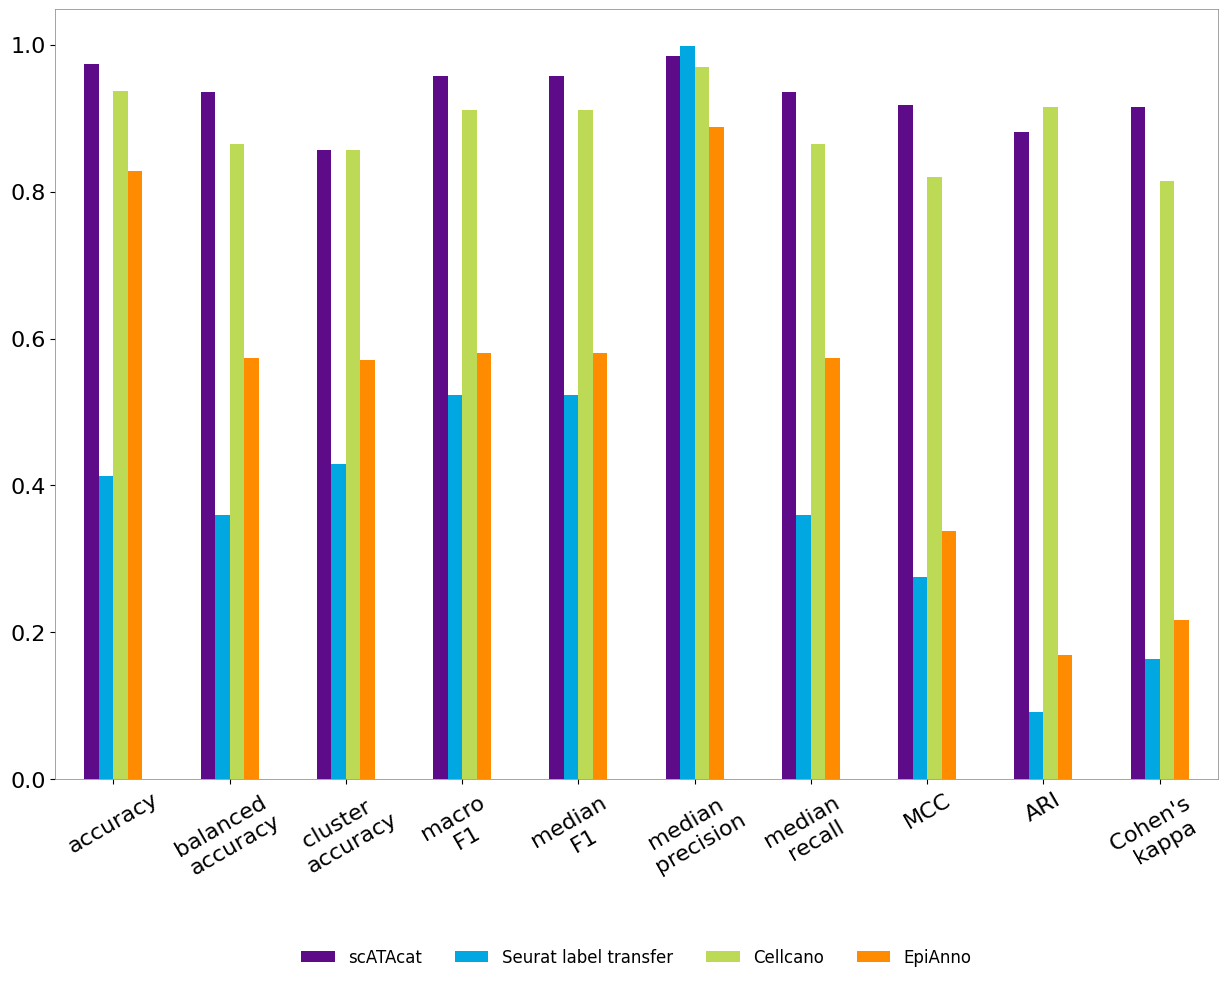

In [55]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_common_annotations.png',x_label_rotation = 30)

## scores for common cells & pairwise common annotations


In [56]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1.0'
for method in scores_df.index:
    if method == "scATAcat":
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        print(predicted_id_col)
        print(common_annotations)
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations_simplified"
        print(predicted_id_col)
        print(common_annotations)
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        print(predicted_id_col)
        print(common_annotations)
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        print(predicted_id_col)
        print(common_annotations)
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


scATAcat_annotation
['GLU', 'OLIG', 'GABA', 'MGAS']
label_transfer_annotations_simplified
['GLU', 'OLIG', 'GABA', 'MGAS']
Cellcano_annotations_simplified
['GLU', 'OLIG', 'GABA', 'MGAS']
EpiAnno_annotations_simplified
['OLIG', 'MGAS']


In [57]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,cluster_accuracy
scATAcat,0.707338,0.706282,0.518999,0.55948,0.511049,0.912564,0.604595,0.816436,0.539703,0.750000
Seurat_label_transfer,0.347726,0.456365,0.33149,0.312067,0.848687,0.360238,0.318396,0.057073,0.208071,0.500000
Cellcano,0.676895,0.624653,0.466306,0.43395,0.770171,0.755148,0.568662,0.881444,0.513128,0.625000
EpiAnno,0.828636,0.573935,0.58098,0.58098,0.887479,0.573935,0.338515,0.168769,0.216202,0.571429


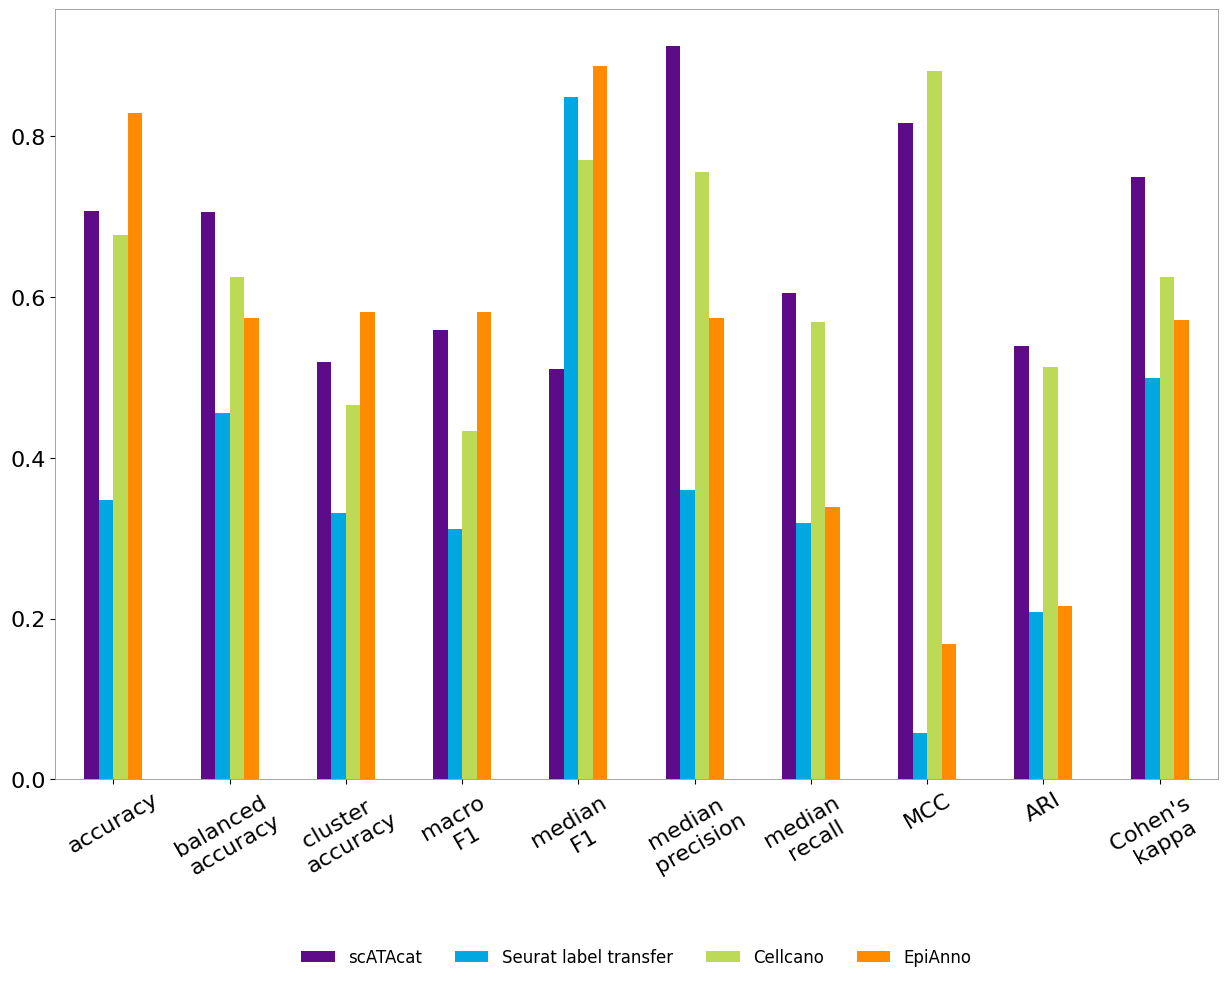

In [58]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_pairwise_common_annotations.png',x_label_rotation = 30)